In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
title_basics = pd.read_csv('./Data/imdb.title.basics.csv.gz')
title_ratings = pd.read_csv("./Data/imdb.title.ratings.csv.gz")
movie_budgets = pd.read_csv('./Data/tn.movie_budgets.csv.gz')

In [3]:
title_basics.rename(columns = {'primary_title':'movie'}, inplace = True)
title_basics.drop(columns = ["original_title","runtime_minutes"], inplace=True)

In [4]:
title_basics['genres'].isna().sum()/146144*100

3.7004598204510617

In [5]:
title_basics.dropna(subset= ['genres'], inplace = True)

In [6]:
# change release date to date-time
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

In [7]:
# change production_budget, domestic_gross, and worldwide_budget to integers
movie_budgets['production_budget'] = movie_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(float)
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

In [8]:
movie_budgets.drop(columns = ["id"], inplace=True)
# drop rows where worldwide_gross or production_budget is 0
movie_budgets = movie_budgets[movie_budgets.worldwide_gross != 0]
movie_budgets = movie_budgets[movie_budgets.production_budget != 0]

In [9]:
# add a profit column to movie_budgets
movie_budgets['profit'] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

In [10]:
# calculate profit in millions
movie_budgets['profit_million']=(movie_budgets['profit']/1000000)

In [11]:
# calculate production budget in millions
movie_budgets['production_budget_million']=(movie_budgets['production_budget']/1000000)

In [12]:
# add a column ROI calculating the return on investment
movie_budgets['ROI'] = (movie_budgets['profit'] / movie_budgets['production_budget']) * 100
# round ROI to 2 decimal places
movie_budgets = movie_budgets.round({'ROI': 2})

In [13]:
# add a column for movie year
movie_budgets['year'] = pd.DatetimeIndex(movie_budgets['release_date']).year

In [14]:
movie_budgets.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,profit_million,production_budget_million,ROI,year
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,2351.345279,425.0,553.26,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,635.063875,410.6,154.67,2011
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,-200.237650,350.0,-57.21,2019
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,1072.413963,330.6,324.38,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,999.721747,317.0,315.37,2017


# Merge Data Tables

In [15]:
# merge title_basics and title_ratings on tconst
imdb_data = pd.merge(title_basics, title_ratings, how = 'inner', on = 'tconst')
imdb_data.head()

,tconst,movie,start_year,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,2018,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.5,119


In [16]:
# merge imdb_data with movie_budgets
mdf = pd.merge(imdb_data, movie_budgets, how = 'inner', on = 'movie')

In [17]:
#move the movies with the most votes on imdb up to top
mdf=mdf.sort_values(by='numvotes', ascending = False)

In [18]:
mdf['same_year']= mdf['start_year']-mdf['year']
mdf = mdf.loc[mdf['same_year']== 0]

In [19]:
mdf = mdf.drop_duplicates(subset='movie')
mdf.drop(columns = ["tconst"], inplace=True)

In [20]:
mdf["genres"] = mdf["genres"].apply(lambda x: x.split(",") if type(x) == str else x)

In [21]:
# filter for movies released after 1990 
mdf = mdf.loc[mdf['year'] >= 2010]

In [25]:
mdf = mdf.loc[mdf['ROI'] > 0]

In [26]:
#explode the genres
mdf2 = mdf.explode('genres')

In [27]:
mdf2

,movie,start_year,genres,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_million,production_budget_million,ROI,year,same_year
510,Inception,2010,Action,8.8,1841066,2010-07-16,160000000.0,292576195.0,8.355246e+08,675524642.0,675.524642,160.0,422.20,2010,0
510,Inception,2010,Adventure,8.8,1841066,2010-07-16,160000000.0,292576195.0,8.355246e+08,675524642.0,675.524642,160.0,422.20,2010,0
510,Inception,2010,Sci-Fi,8.8,1841066,2010-07-16,160000000.0,292576195.0,8.355246e+08,675524642.0,675.524642,160.0,422.20,2010,0
477,The Dark Knight Rises,2012,Action,8.4,1387769,2012-07-20,275000000.0,448139099.0,1.084439e+09,809439099.0,809.439099,275.0,294.34,2012,0
477,The Dark Knight Rises,2012,Thriller,8.4,1387769,2012-07-20,275000000.0,448139099.0,1.084439e+09,809439099.0,809.439099,275.0,294.34,2012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,Sea Rex 3D: Journey to a Prehistoric World,2010,Documentary,6.9,364,2010-05-28,5000000.0,6096582.0,1.651520e+07,11515203.0,11.515203,5.0,230.30,2010,0
1429,Sholem Aleichem: Laughing in the Darkness,2011,Documentary,6.8,157,2011-07-08,500000.0,1131261.0,1.131261e+06,631261.0,0.631261,0.5,126.25,2011,0
1481,The Great Wall,2017,Documentary,6.5,24,2017-02-17,150000000.0,45157105.0,3.344869e+08,184486852.0,184.486852,150.0,122.99,2017,0
1931,All You Need Is Love,2014,Documentary,6.8,9,2014-10-31,300000.0,0.0,3.565259e+06,3265259.0,3.265259,0.3,1088.42,2014,0


In [28]:
no_gallows = mdf2.drop(index = 1722).sort_values(by="ROI",ascending = False)
no_gallows = no_gallows.drop(index = 782).sort_values(by='ROI', ascending=False)

In [31]:
no_gallows

,movie,start_year,genres,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_million,production_budget_million,ROI,year,same_year
755,Paranormal Activity 2,2010,Horror,5.7,93122,2010-10-20,3000000.0,84752907.0,177512032.0,174512032.0,174.512032,3.0,5817.07,2010,0
2402,Get Out,2017,Horror,7.7,400474,2017-02-24,5000000.0,176040665.0,255367951.0,250367951.0,250.367951,5.0,5007.36,2017,0
2402,Get Out,2017,Thriller,7.7,400474,2017-02-24,5000000.0,176040665.0,255367951.0,250367951.0,250.367951,5.0,5007.36,2017,0
2402,Get Out,2017,Mystery,7.7,400474,2017-02-24,5000000.0,176040665.0,255367951.0,250367951.0,250.367951,5.0,5007.36,2017,0
2393,Moonlight,2016,Drama,7.4,227964,2016-10-21,1500000.0,27854931.0,65245512.0,63745512.0,63.745512,1.5,4249.70,2016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,Stoker,2013,Thriller,6.8,97393,2013-03-01,12000000.0,1703125.0,12034913.0,34913.0,0.034913,12.0,0.29,2013,0
994,Stoker,2013,Drama,6.8,97393,2013-03-01,12000000.0,1703125.0,12034913.0,34913.0,0.034913,12.0,0.29,2013,0
148,Hugo,2011,Adventure,7.5,284869,2011-11-23,180000000.0,73864507.0,180047784.0,47784.0,0.047784,180.0,0.03,2011,0
148,Hugo,2011,Drama,7.5,284869,2011-11-23,180000000.0,73864507.0,180047784.0,47784.0,0.047784,180.0,0.03,2011,0


In [32]:
sorted_genres2 = no_gallows.groupby(["genres"], as_index=False).mean().sort_values(by = "ROI", ascending=False)

top5genres_v2 = list(sorted_genres2['genres'].values[0:5])
top5genres_v2

['Horror', 'Mystery', 'Thriller', 'Musical', 'Biography']

In [33]:
sorted_genres2

,genres,start_year,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,profit,profit_million,production_budget_million,ROI,year,same_year
11,Horror,2014.453704,5.810185,92162.203704,2.159792e+07,4.771430e+07,1.051221e+08,8.352416e+07,83.524158,21.597917,892.908148,2014.453704,0.0
14,Mystery,2014.177778,6.287778,162969.644444,2.911125e+07,5.305549e+07,1.226729e+08,9.356169e+07,93.561693,29.111252,781.217333,2014.177778,0.0
18,Thriller,2013.884393,6.282081,165496.289017,4.010788e+07,6.362149e+07,1.668024e+08,1.266945e+08,126.694500,40.107877,582.025029,2013.884393,0.0
13,Musical,2014.250000,7.075000,135745.000000,7.682500e+07,1.804056e+08,4.468113e+08,3.699863e+08,369.986349,76.825000,406.085000,2014.250000,0.0
3,Biography,2014.852273,7.222727,153770.738636,2.821330e+07,5.641716e+07,1.171555e+08,8.894218e+07,88.942179,28.213295,392.459091,2014.852273,0.0
6,Documentary,2012.705882,6.347059,14655.294118,1.409853e+07,2.127135e+07,4.544084e+07,3.134231e+07,31.342312,14.098529,381.481765,2012.705882,0.0
7,Drama,2013.870690,6.764224,138254.855603,3.105727e+07,4.866020e+07,1.077761e+08,7.671886e+07,76.718863,31.057269,368.058772,2013.870690,0.0
15,Romance,2012.985507,6.403623,96936.500000,2.633163e+07,4.333942e+07,8.983322e+07,6.350159e+07,63.501590,26.331630,364.430145,2012.985507,0.0
12,Music,2013.750000,6.413889,87163.638889,2.066389e+07,4.554701e+07,1.000802e+08,7.941636e+07,79.416357,20.663889,362.126667,2013.750000,0.0
16,Sci-Fi,2014.333333,6.745098,341202.176471,1.145252e+08,1.621483e+08,4.458693e+08,3.313440e+08,331.344011,114.525245,361.363529,2014.333333,0.0


In [34]:
nsort = no_gallows.groupby(["genres"], as_index=False).mean().sort_values(by = "ROI", ascending=True)

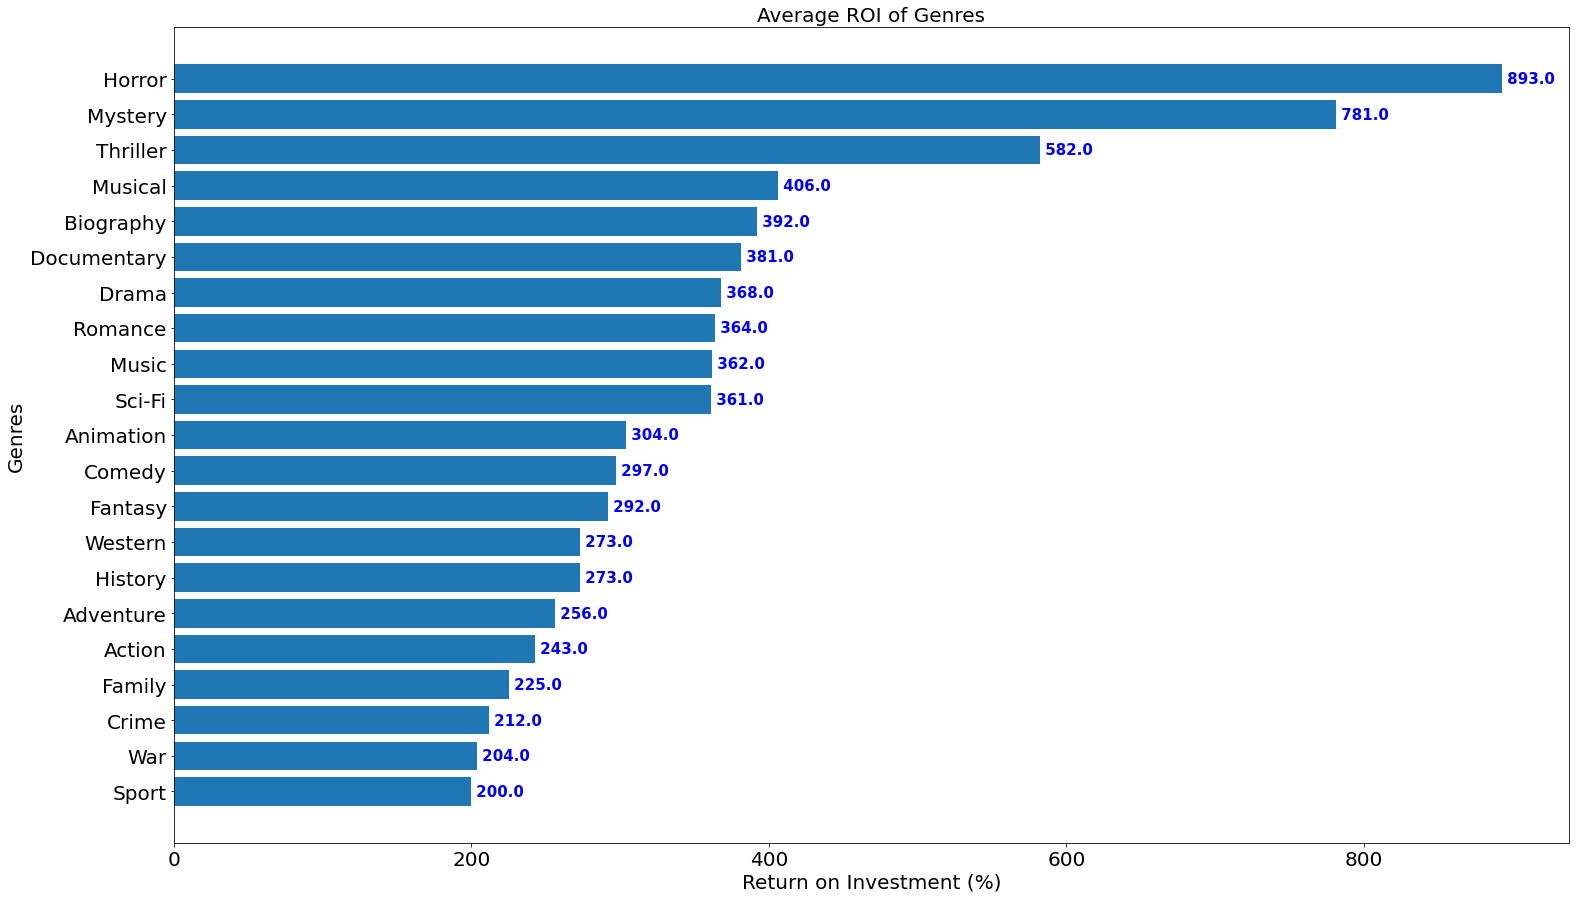

In [35]:
fig, ax = plt.subplots(figsize=(25, 15))
x = nsort['genres']
y = nsort['ROI']
y = y.round()
ax.barh(x, y)
ax.set_title('Average ROI of Genres')
ax.set_xlabel('Return on Investment (%)')
ax.set_ylabel('Genres')

for i, v in enumerate(y):
    ax.text(v, i, " "+str(v), color='blue', va='center', fontweight='bold', fontsize= 15)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

plt.savefig('image.jpg')